## 6. Nonlinear ensemble filtering for the Lorenz-63 problem

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [6]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

Load some packages to make nice figures

In [7]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [8]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [9]:
Δtdyn = 0.05
Δtobs = 0.1

0.1

Define the additive inflation for the dynamical and observation models

Define the time span of interest

In [10]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, tf/Δtobs)

1000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [11]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(t,x) = x$.

In [12]:
h(t,x) = x
F = StateSpace(lorenz63!, h)

StateSpace(AdaptiveTransportMap.lorenz63!, h)

In [13]:
σx = 1e-2
σy = 2.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0])

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\boldsymbol{x}^i$ o generate i.i.d. samples from the system’s invariant (long-time) distribution, we sampleninitialconditions from a multivariate standard Gaussian distribution.  For each sample, we run the ODEin equation(SM.25)forT=  40,000steps using the Runge-Kutta method with a time-step of∆t= 0.01. The samples of the state at the final time are then i.i.d. samples from the push-forwarddistribution of the standard Gaussian through the nonlinear forward dynamics forTsteps

In [15]:
# Number of runs
Ne = 300
# Zero vector of the size of the state
x0 = rand(π0)

# Time stepp
tspan = (0.0, 500.0)
prob = ODEProblem(lorenz63!, x0, tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 500.0)
u0: [1.8704982230374803, -0.33754314389900925, 1.2008229787081561]

Create cache to store the different final solutions

In [25]:
X = zeros(Ny + Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`, and compute the associated observation vector.

In [26]:
@inbounds for i=1:Ne
    prob = remake(prob; u0 = rand(π0))
    sol = solve(prob, Tsit5(), dt = 0.01, adaptive = false, dense = false, saveat = tspan[end], save_start = false)
    # Store the state
    X[Ny+1:Ny+Nx,i] .= deepcopy(sol.u[1])
end
# Apply the process noise
ϵx(X, Ny+1, Ny+Nx)
# Generate the observations
observe(h, tf, X, Ny, Nx)
# Apply the observation noise
ϵy(X, 1, Ny)

In [29]:
m = 30
S = HermiteMap(m, X; diag = true)

HermiteMap(30, 6, LinearTransform(6, [0.2452847107177989, -0.041529178565395904, 23.680037506755834, -0.7319102738497861, -1.0463228214577358, 22.735125193857552], [7.763007530290495 0.0 … 0.0 0.0; 0.0 9.141042925589339 … 0.0 0.0; … ; 0.0 0.0 … 9.098498120709031 0.0; 0.0 0.0 … 0.0 8.845476988139383], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 1 active features
, Map component of dimension 3 with Nψ 1 active features
, Map component of dimension 4 with Nψ 1 active features
, Map component of dimension 5 with Nψ 1 active features
, Map component of dimension 6 with Nψ 1 active features
])

In [30]:
@time optimize(S, X, "split"; withqr = true, verbose = false)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  8.348800 seconds (18.21 M allocations: 1.957 GiB, 3.77% gc time)


HermiteMap(30, 6, LinearTransform(6, [0.2452847107177989, -0.041529178565395904, 23.680037506755834, -0.7319102738497861, -1.0463228214577358, 22.735125193857552], [7.763007530290495 0.0 … 0.0 0.0; 0.0 9.141042925589339 … 0.0 0.0; … ; 0.0 0.0 … 9.098498120709031 0.0; 0.0 0.0 … 0.0 8.845476988139383], true), MapComponent[Map component of dimension 1 with Nψ 18 active features
, Map component of dimension 2 with Nψ 18 active features
, Map component of dimension 3 with Nψ 18 active features
, Map component of dimension 4 with Nψ 18 active features
, Map component of dimension 5 with Nψ 18 active features
, Map component of dimension 6 with Nψ 18 active features
])

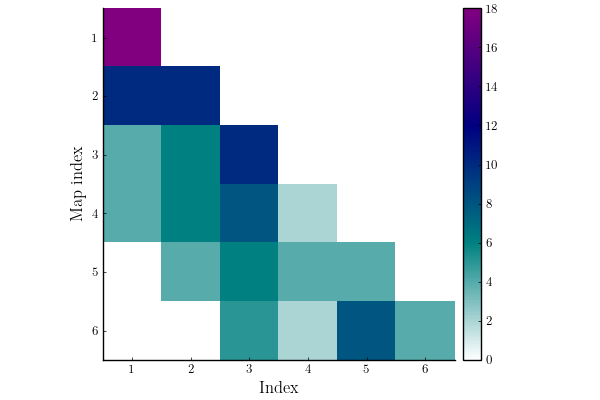

In [31]:
plot(S)

In [32]:
Ωhat = zeros(Ny + Nx, Ny + Nx)
cache = zeros(1, Ny + Nx, Ny + Nx)
for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

6×6 Array{Float64,2}:
 5.15344e8  2.23483e7  1.17958e5  1.54262e8  0.0        0.0
 2.23483e7  2.1814e9   1.46868e5  8.59098e5  1.91096e9  0.0
 1.17958e5  1.46868e5  2.94165e9  1.57086e6  3.98788e5  3.15686e9
 1.54262e8  8.59098e5  1.57086e6  2.31788e8  5.81671e6  1.61571e6
 0.0        1.91096e9  3.98788e5  5.81671e6  2.13905e9  1.68791e5
 0.0        0.0        3.15686e9  1.61571e6  1.68791e5  3.79416e9

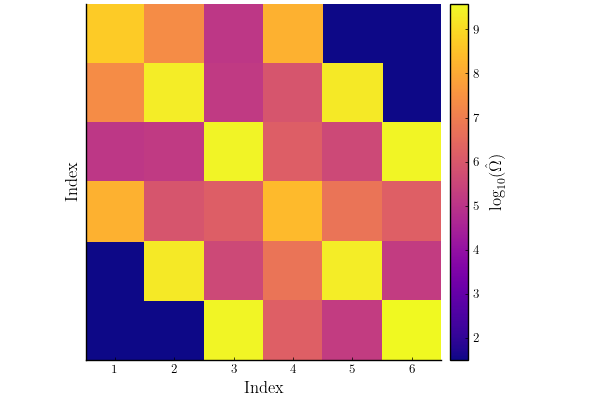

In [33]:
plt = plot()

heatmap!(plt,log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (1.5, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt

In [67]:
smf = StochMapFilter(x->x,ϵy, S, Ny, Nx, Δtdyn, Δtobs, Inf, false)

Stochastic Map Filter with filtered = false


In [68]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

Set initial condition of the true system

In [69]:
x0 = rand(model.π0);

In [70]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [71]:
Ne = 300 #ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×300 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
  0.368571  1.11591  -1.52577   …  -0.691605   0.440048   0.624675
 -1.21346   1.76042  -0.769364      0.158452   0.418134   0.0537213
 -0.022879  1.66874   0.310488      0.229434  -1.56562   -0.75024

In [72]:
Xsmf = seqassim(F, data, Tf, model.ϵx, smf, deepcopy(X), model.Ny, model.Nx, t0);

getcoeff(M[Nypx]) = [6.836048428321437, 21.034734516869584, 456.73674527003794, 4.993348335875259, -0.15317949474258938, 19.876474726234964, 340.282566345524, -13.636149019746838, -307.2295553210629, -4.332383029196262]
M.L.μ = [-5.702077713485371, -6.049957270182448, 26.259568222434858, -6.738501169708745, -7.0413747184213324, 25.255705170731332]
M.L.μ = [1.0928068961901345, 1.1067618828383965, 1.184479891811855, 0.06365575382628663, 0.1350014160998844, 0.20053165076309448]
getcoeff(M[Nypx]) = [6.836048428321437, 21.034734516869584, 456.73674527003794, 4.993348335875259, -0.15317949474258938, 19.876474726234964, 340.282566345524, -13.636149019746838, -307.2295553210629, -4.332383029196262]
1 terms - Training error: 1.380505716453941, Validation error: 1.5643364668742676
1 terms - Training error: 1.3804135313306174, Validation error: 1.5651661329841806
2 terms - Training error: 1.3755754418689186, Validation error: 1.5626612647979032
3 terms - Training error: 1.3742059945301324, Valida

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


18 terms - Training error: -0.014588108246988434, Validation error: 0.358580002663319
1 terms - Training error: 1.431545285346085, Validation error: 1.3601781913056905
1 terms - Training error: 1.4315321788020625, Validation error: 1.3602961502018915
2 terms - Training error: 1.3825242532455408, Validation error: 1.3442698791556078
3 terms - Training error: 1.3818612729242288, Validation error: 1.3472394398338396
4 terms - Training error: 1.3757566588140706, Validation error: 1.3563595341360466
5 terms - Training error: 1.3725103785383916, Validation error: 1.3527644668633223
6 terms - Training error: 1.3709791799203972, Validation error: 1.3465406339313268
7 terms - Training error: 1.3584810505032736, Validation error: 1.331170927174607
8 terms - Training error: 1.358272224300921, Validation error: 1.3327713412776412
9 terms - Training error: 1.3563937373500938, Validation error: 1.3479949311768826
10 terms - Training error: 1.3563377595205013, Validation error: 1.347150939231176
11 t

Progress:  33%|█████████████▋                           |  ETA: 0:00:00

6 terms - Training error: 1.1394299892029454, Validation error: 1.2210333724512936
7 terms - Training error: 1.002586980337407, Validation error: 1.0579070314452872
8 terms - Training error: 1.0005287309177193, Validation error: 1.0749241631957795
9 terms - Training error: 0.646654933789843, Validation error: 0.8155990283749314
10 terms - Training error: 0.6464156878912451, Validation error: 0.8180614623389588
11 terms - Training error: 0.644974107553212, Validation error: 0.8311509577973847
12 terms - Training error: 0.6399655660509647, Validation error: 0.8317053903917594
13 terms - Training error: 0.6379822703026489, Validation error: 0.8416298863237548
14 terms - Training error: 0.6315449026123948, Validation error: 0.8665886627204824
15 terms - Training error: 0.6309289704246651, Validation error: 0.8502398982851778
16 terms - Training error: 0.5982574089011738, Validation error: 0.7403363005362538
17 terms - Training error: 0.5975989558141377, Validation error: 0.7489101277734008

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:00

18 terms - Training error: -0.9614698426397351, Validation error: -0.17463193506769112
1 terms - Training error: 1.3982386164130947, Validation error: 1.4934048670376519
1 terms - Training error: 1.3982003279258675, Validation error: 1.493749463422696
2 terms - Training error: 1.3339692539432277, Validation error: 1.467301546256935
3 terms - Training error: 1.3235831881887063, Validation error: 1.459389825937452
4 terms - Training error: 1.1626484591581883, Validation error: 1.2460849404236352
5 terms - Training error: 1.1268554310839338, Validation error: 1.2359416584352572
6 terms - Training error: 1.1034942180083285, Validation error: 1.2673830008592257
7 terms - Training error: 1.0895860621361033, Validation error: 1.244042233836006
8 terms - Training error: 1.0619377847102336, Validation error: 1.3178819245433495
9 terms - Training error: 1.0537588035203995, Validation error: 1.260745753520858
10 terms - Training error: 1.0473907328884224, Validation error: 1.2193756325804317
11 t

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


15 terms - Training error: 0.993547616264511, Validation error: 1.1407681432832373
16 terms - Training error: 0.9916661155048464, Validation error: 1.1791012480996317
17 terms - Training error: 0.9901513781520687, Validation error: 1.1917385150481603
18 terms - Training error: 0.977761992417689, Validation error: 1.1865008672172632
converged(result) = true
converged(result) = true
converged(result) = true
getcoeff(M[Nypx]) = [-7.021927944856285, 15.278176623023565, -1.7257429779985385, -3.409719560139809, 4.488072712520406, 11.169916132061, 5.605918587772989, 4.3001038253999235, 2.639592434487083, -0.420370374158831, -2.0029909105637094, 0.5516235306386053, 0.6235348373271797, 2.3445981994059797, 0.04078927515843003, 1.2410398035389616, -0.17565357849527996, 0.9890396962355894]
getcoeff(M[Nypx]) = [-7.021927944856285, 15.278176623023565, -1.7257429779985385, -3.409719560139809, 4.488072712520406, 11.169916132061, 5.605918587772989, 4.3001038253999235, 2.639592434487083, -0.420370374158

Progress:  33%|█████████████▋                           |  ETA: 0:00:00

13 terms - Training error: -0.04937493496167861, Validation error: 0.02693792322216866
14 terms - Training error: -0.2663974923470452, Validation error: -0.21616339742433724
15 terms - Training error: -0.370905214639117, Validation error: -0.3801728985322531
16 terms - Training error: -0.43674845560792197, Validation error: -0.4476690214216653
17 terms - Training error: -0.46870364476102155, Validation error: -0.4476092533658104
18 terms - Training error: -0.47112706151802813, Validation error: -0.4515115984050412
1 terms - Training error: 1.4410480609670957, Validation error: 1.3221670888216475
1 terms - Training error: 1.441047337143977, Validation error: 1.322173603229716
2 terms - Training error: 1.127340482462005, Validation error: 1.0876938325077883
3 terms - Training error: 1.0404938953969813, Validation error: 1.024533225220379
4 terms - Training error: 0.9782723078947685, Validation error: 0.9951822443607656
5 terms - Training error: 0.6887862409942385, Validation error: 0.646

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:00

11 terms - Training error: -2.0691698416656865, Validation error: -2.118255097533692
12 terms - Training error: -2.0969798962647195, Validation error: -2.1204007906583144
13 terms - Training error: -2.0975664881546074, Validation error: -2.1214408066530552
14 terms - Training error: -2.1060703572505384, Validation error: -2.124415508280153
15 terms - Training error: -2.107431621306844, Validation error: -2.124127208460792
16 terms - Training error: -2.10852838641157, Validation error: -2.1190413179079073
17 terms - Training error: -2.109582132819345, Validation error: -2.112548434165213
18 terms - Training error: -2.11242933128017, Validation error: -2.108897399526872
1 terms - Training error: 1.43562323607526, Validation error: 1.3438663883889905
1 terms - Training error: 1.4355811783514847, Validation error: 1.3442449079029646
2 terms - Training error: 1.1080472988899426, Validation error: 1.0907238924857976
3 terms - Training error: 0.9783714231942585, Validation error: 0.9785888826

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


14 terms - Training error: -0.0024708193381349788, Validation error: 0.16139550193132726
15 terms - Training error: -0.016016524479314148, Validation error: 0.12550103691703288
16 terms - Training error: -0.02469222182071406, Validation error: 0.11727809548963906
17 terms - Training error: -0.02678657753223589, Validation error: 0.12521468334360725
18 terms - Training error: -0.03339431014785349, Validation error: 0.10990127894337914
converged(result) = true


LoadError: [91mLineSearches.LineSearchException{Float64}("Value and slope at step length = 0 must be finite.", 0.0)[39m

In [114]:
# Plot the first component of the state over time
nb = 5800
ne = 6000
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsmf)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "sEnKF")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

LoadError: [91mBoundsError: attempt to access 3000-element Array{Float64,1} at index [5800][39m

In [84]:
?StateSpace

search: StateSpace



```
StateSpace
```

An immutable structure representing the dynamical `f` and observation `h` operators. The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model. We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. `h` must be a function of the form `h(x, t)`, where `t` is the time and `x` is the state vector.


In [115]:
# Plot the different component of the state over time
nb = 5500
ne = 6000
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (900, 1000))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  2, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xsmf)[i,1+nb:Δ:1+ne], linewidth = 2, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

LoadError: [91mBoundsError: attempt to access 3000-element Array{Float64,1} at index [5500][39m

Talk about the benchmark of the different filters

### Benchmark of the EnKF filter

In [116]:
path = pwd()*"/lorenz63/data/"
Nx = 3
Ny = 3
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz63(path, Ne_array);

Ne 10 RMSE: 3.8254663423276716
Ne 20 RMSE: 2.0605921219961134
Ne 40 RMSE: 0.4223537564608097
Ne 60 RMSE: 0.40146546759545937
Ne 100 RMSE: 0.3877197292448612
Ne 200 RMSE: 0.4025809532902939
 15.443304 seconds (68.89 M allocations: 6.501 GiB, 6.17% gc time)


In [55]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (10, 1.0)
  0.482682 seconds (3.47 M allocations: 329.564 MiB, 11.44% gc time)
Ne = 10
Ne 10& β 1.0 RMSE: 0.6015590736992926


Progress:  17%|██████▉                                  |  ETA: 0:00:05

(Ne, β) = (20, 1.0)
  

Progress:  33%|█████████████▋                           |  ETA: 0:00:04

0.859515 seconds (6.59 M allocations: 631.994 MiB, 8.56% gc time)
Ne = 20
Ne 20& β 1.0 RMSE: 0.5184477645494938
(Ne, β) = (40, 1.0)
  

Progress:  50%|████████████████████▌                    |  ETA: 0:00:04

1.662244 seconds (12.83 M allocations: 1.210 GiB, 8.65% gc time)
Ne = 40
Ne 40& β 1.0 RMSE: 0.4483744816193398
(Ne, β) = (60, 1.0)
  

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:03

2.463622 seconds (19.07 M allocations: 1.804 GiB, 8.51% gc time)
Ne = 60
Ne 60& β 1.0 RMSE: 0.4403101469791623
(Ne, β) = (100, 1.0)
  

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:02

4.334649 seconds (31.55 M allocations: 2.983 GiB, 8.49% gc time)
Ne = 100
Ne 100& β 1.0 RMSE: 0.4303647629868742
(Ne, β) = (200, 1.0)
 13.776164 seconds (62.75 M allocations: 5.935 GiB, 7.19% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4465248257137066

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


6-element Array{Any,1}:
 Metrics[Metrics(10, [0.8166106052280312, 0.8477976249831615, 0.5377435004826744, 0.2946057216215732, 0.1963372890873663, 0.1661211989653268, 0.09550122139602638, 0.10895691501209233, 0.061645037116889324, 0.1556247918798692  …  4.0942175082812975, 2.918216773645667, 2.293946056603929, 2.3368525142834664, 2.9966610036699945, 2.488711153121422, 2.060789991067101, 2.000268585410395, 2.0094430111553767, 1.633586039615903], 0.37686107778341077, 0.6015590736992926, 0.8149386709205617, [1.0125271950095414, 0.9623361052178709, 0.7792957424814254, 0.4344193482216172, 0.2873587820499424, 0.2729751953413108, 0.40382950988831384, 0.6108278943470481, 0.6592219807793599, 0.4157011617649463  …  0.6622613427311322, 0.9156031963385003, 1.1880540752197546, 1.010250360884169, 0.9055102239545725, 0.6429162631150634, 0.5592022167774022, 0.6557579770729094, 0.987851621549649, 1.1234614213819019], 0.4419068954362283, 0.5053138269227165, 0.25903240927442023, [1.0, 1.0, 0.6666666666666

In [23]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (200, 1.0)
  7.739944 seconds (62.75 M allocations: 5.935 GiB, 6.06% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4189442707516625


1-element Array{Any,1}:
 Metrics[Metrics(200, [0.27418871478089074, 0.4011111920900346, 0.6224367042654201, 1.1940241372680338, 1.178706937442249, 0.629896584355798, 0.37352902606306937, 0.27598562967074297, 0.3415108073527272, 0.5385900049790774  …  0.22005926456584765, 0.11117371050261328, 0.0745833426310767, 0.06915409494524392, 0.23566185689849842, 0.4284533696688461, 0.7382482677445492, 1.2785156926466672, 0.9477650979445261, 0.8579855755647071], 0.2843509443072877, 0.4189442707516625, 0.3843942458358231, [0.2791191166770778, 0.3308824803118106, 0.5356751453956368, 0.7482658949655999, 0.6849666981780923, 0.5401293761758875, 0.3905840265207302, 0.30529026491290673, 0.3612676308031941, 0.5506587576884893  …  0.9550452598208562, 0.7275900415277436, 0.5097020874896808, 0.38068472189933705, 0.44668108906035564, 0.6711198461183089, 0.7934070557338772, 0.953289237580203, 1.0821830718436276, 1.1373384160933897], 0.529889526630428, 0.584733698922179, 0.23401428353181045, [1.0, 1.0, 1.0, 1.